In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle

In [3]:

def load_artifact(targ_file:str):
    targ_path = os.path.join(dir,targ_file)

    with open(targ_path,'rb') as fp:
        test_artifact = pickle.load(fp)

    return test_artifact

In [4]:
# Each time that you initialize Dagster a new temporary folder is created.
# For the porpuse of this exercise we will save data in that temporary folder.
# Substitute tmp*** with your folder (you can fin it in this repo).
dir = "../tmpu29zieeu/storage/"

`core_data`

| Feature Name           | Description                                                  |
|------------------------|--------------------------------------------------------------|
| rating_account_id      | Unique identifier for the contract account                    |
| customer_id            | Unique identifier for the customer                           |
| age                    | Age of the customer                                          |
| contract_lifetime_days | Total duration of the customer contract in days              |
| remaining_binding_days | Number of days left in the contract binding period - usual binding period is 2 years        |
| has_special_offer      | Indicates if the customer has a special offer      |
| is_magenta1_customer   | Indicates if the customer is part of the Magenta1 program - fedelty program    |
| available_gb           | Amount of mobile data included in the current tariff         |
| gross_mrc              | Gross monthly recurring charge (in euros)                    |
| smartphone_brand       | Brand of the customer’s smartphone                           |
| has_done_upselling     | Whether the customer has already done an upsell in the last 3 years      |


In [5]:
core_data = load_artifact("core_data")
core_data

,rating_account_id,customer_id,age,contract_lifetime_days,remaining_binding_days,has_special_offer,is_magenta1_customer,available_gb,gross_mrc,smartphone_brand,has_done_upselling
0,278788,5.200192,42,958,137,0,0,40,55.41,Samsung,0
1,638234,5.127164,48,73,68,0,0,30,51.43,iPhone,0
2,937207,4.605381,34,612,224,1,0,30,38.16,Samsung,0
3,172992,1.609815,25,251,-70,1,0,10,66.02,Samsung,0
4,420234,3.226236,40,825,594,1,0,20,18.27,iPhone,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,357306,5.648046,100,1803,-233,0,0,40,42.14,iPhone,0
99996,347276,1.135615,75,1196,-581,1,0,30,55.41,Samsung,0
99997,659202,4.932057,85,1554,231,0,0,None,26.22,Samsung,0
99998,941233,2.730076,98,1210,-99,1,1,40,27.55,iPhone,0


`usage_info`

| Feature Name           | Description                                                  |
|------------------------|--------------------------------------------------------------|
| rating_account_id      | Unique identifier for the contract account                    |
| billed_period_month_d  | Billing period (monthly)                                     |
| has_used_roaming       | Indicates if roaming was used during the period            |
| used_gb                | Amount of mobile data used in the billing period (in GB)     |


In [6]:
usage_info = load_artifact("usage_info")
usage_info

,rating_account_id,billed_period_month_d,has_used_roaming,used_gb
0,278788,2024-04-01,1,0.2
1,278788,2024-05-01,0,0.5
2,278788,2024-06-01,0,1.0
3,278788,2024-07-01,0,0.6
4,638234,2024-04-01,0,0.9
...,...,...,...,...
399995,941233,2024-07-01,1,24.6
399996,535527,2024-04-01,0,68.5
399997,535527,2024-05-01,1,57.8
399998,535527,2024-06-01,0,15.0


`customer_interactions`

| Feature Name   | Description                                                              |
|----------------|--------------------------------------------------------------------------|
| customer_id    | Unique identifier for the customer                                       |
| type_subtype   | Category and subtype of the interaction (e.g., tariff change, billing)   |
| n              | Number of interactions of this type in the last 6 months                                |
| days_since_last| Number of days since the last interaction of this type                   |


In [7]:
customer_interactions = load_artifact("customer_interactions")
customer_interactions

,customer_id,type_subtype,n,days_since_last
0,3.592423,produkte&services-tarifdetails,2,75
1,3.592423,produkte&services-tarifwechsel,1,162
2,1.347316,prolongation,2,86
3,5.686529,produkte&services-tarifdetails,1,171
4,5.702062,produkte&services-tarifdetails,1,49
...,...,...,...,...
63176,1.661147,rechnungsanfragen,2,150
63177,5.578683,prolongation,1,141
63178,5.578683,produkte&services-tarifdetails,3,47
63179,3.895532,rechnungsanfragen,1,147



## Upselling Prediction

### Given

- **Goal:** Identify which customers to target for upselling campaigns (upgrade to a better, more expensive product).

- **Data Sources**
  - **core_data:** contract-level information
  - **usage_info:** data usage and roaming activity from the past **3 months** *(or 4 months — TODO: verify in `get_data.py`)*
  - **customer_interactions:** customer service interaction records in the last **6 months**

*(All columns and explanations are provided in the repo’s `get_data.py`. This notebook cross-checks that the EDA aligns with synthetic generation assumptions.)*

- **Target:** `core_data.has_done_upselling` (last 3 years).  
  Ensure **temporal coherence**: features are available **before** the decision point (no leakage).

- **Join Keys**
  - `core_data.rating_account_id` - `usage_info.rating_account_id`
  - `core_data.customer_id` - `customer_interactions.customer_id`

### Prior Notes

Data is created synthetically under:  
`/workspaces/magenta-ds-interview-task/src/code_location_interview/code_location_interview/assets/magenta_interview/get_data.py`  

Use this as a **sanity check** for processing:
- Does the generated data make business sense?
- Do EDA patterns match data-generation assumptions?

### First observations (from data creation)

Bias towards upsell expected for:
- **Younger** customers: `age < 45`
- **Newer** customers: `300 ≤ contract_lifetime_days ≤ 4*365`
- **Near end of binding**: `remaining_binding_days < 60`
- **Magenta1 members**: `is_magenta1_customer == 1`
- **Low data allowance**: `available_gb ≤ 20`
- **Lower price**: `gross_mrc < 35`

Class imbalance expected: **~0.07** positive rate.

### Initial hypotheses to test

- **Demographics:** younger customers more likely to upsell  
- **Timing:** near contract end (low binding days)  
- **Engagement:** membership status helps  
- **Plan:** lower data plan more likely to move up  
- **Price:** lower MRC more likely to accept upsell  
- **Interactions:** positive/handled interactions correlate with upsell

### Notebook Outline

1. Data check, clean, clarify, EDA  
2. Aggregate `usage_info` to rating-account level  
3. Aggregate `customer_interactions` to customer level  
4. Merge into a single training table
5. Baseline & class imbalance check  
6. Decision notes & limitations

> Note: Code is developed in `.py` modules back forth with exploration


In [8]:
import pandas as pd

# make a copy of each set to avoid directly modify the original
core_df = core_data.copy()
usage_df = usage_info.copy()
interactions_df = customer_interactions.copy()

In [9]:
print("##### CORE DATA #####")
core_df.info()
core_df.describe(include='all').T
core_df.head()

##### CORE DATA #####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   rating_account_id       100000 non-null  int64  
 1   customer_id             100000 non-null  object 
 2   age                     100000 non-null  int64  
 3   contract_lifetime_days  100000 non-null  int64  
 4   remaining_binding_days  100000 non-null  int64  
 5   has_special_offer       100000 non-null  int64  
 6   is_magenta1_customer    100000 non-null  int64  
 7   available_gb            85674 non-null   object 
 8   gross_mrc               100000 non-null  float64
 9   smartphone_brand        100000 non-null  object 
 10  has_done_upselling      100000 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 8.4+ MB


,rating_account_id,customer_id,age,contract_lifetime_days,remaining_binding_days,has_special_offer,is_magenta1_customer,available_gb,gross_mrc,smartphone_brand,has_done_upselling
0,278788,5.200192,42,958,137,0,0,40,55.41,Samsung,0
1,638234,5.127164,48,73,68,0,0,30,51.43,iPhone,0
2,937207,4.605381,34,612,224,1,0,30,38.16,Samsung,0
3,172992,1.609815,25,251,-70,1,0,10,66.02,Samsung,0
4,420234,3.226236,40,825,594,1,0,20,18.27,iPhone,0


In [10]:
print("##### USAGE DATA #####")
usage_df.info()
usage_df.describe(include='all').T
usage_df.head()

##### USAGE DATA #####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   rating_account_id      400000 non-null  int64  
 1   billed_period_month_d  400000 non-null  object 
 2   has_used_roaming       400000 non-null  int64  
 3   used_gb                400000 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 12.2+ MB


,rating_account_id,billed_period_month_d,has_used_roaming,used_gb
0,278788,2024-04-01,1,0.2
1,278788,2024-05-01,0,0.5
2,278788,2024-06-01,0,1.0
3,278788,2024-07-01,0,0.6
4,638234,2024-04-01,0,0.9


In [11]:
print("##### INTERACTIONS DATA #####")
interactions_df.info()
interactions_df.describe(include='all').T
interactions_df.head()

##### INTERACTIONS DATA #####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63181 entries, 0 to 63180
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      63181 non-null  object
 1   type_subtype     63181 non-null  object
 2   n                63181 non-null  int64 
 3   days_since_last  63181 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.9+ MB


,customer_id,type_subtype,n,days_since_last
0,3.592423,produkte&services-tarifdetails,2,75
1,3.592423,produkte&services-tarifwechsel,1,162
2,1.347316,prolongation,2,86
3,5.686529,produkte&services-tarifdetails,1,171
4,5.702062,produkte&services-tarifdetails,1,49


## Evaluation of info and describe

The **core data** is 100.000 rows with 11 features, 2 are ids. 

3 features have datatype object. 

- customer_id: leave as object for now. not unique, 58556 customer ids. One customer may have multiple accounts. 
Later when splitting consider this. Could result in target leakage.

- available_gb: address missing values and datatype

- smartphone_brand: code them as categories (5 unique values)


Numeric features:

- has_done_upselling: target is binary with mean 0.07 class imbalance.

- rating_account_id: should be per contract and expect unique. Double check.

- age: 18-100 (makes sense)

- contract_lifetime_days: can be up to 5 years. Check for outliers. Mean aligns with assumption (typical given contract time). Can be put in categories. 

- remaining_binding_days: Can be negative - probably means that customer is out of contract. Can be but in categories.

- has_special_offer and is_magenta1_customer are binary with similar ratios

- gross_mrc: between 5-70 Euros. Can be put in categories

The **usage data** is 400.000 rows with 4 features, 1 is id. Usage for 4 months of 100.000 accounts

- rating_account_id: will be used for join

- billed_period_month_d: datatype to datetime

- has_used_roaming: binary

- used_gb: pay attention to heavy users

The **interaction data** is 63181 rows with 4 features, 1 is id.

- customer_id:not unique, will be used in join. Note that number of unique ids are different than core data

- type_subtype: object. 4 categories

- n:  number of interaction - rename for clarity. Also maybe cap it due to long tail

- days_since_last: can be used for recency

In [12]:
# Core data clean and feature engineering:


# make sure it is account id is unique in core
print("rating_account_id unique count:", core_df["rating_account_id"].nunique())

# make a column indicating if the value was missing
core_df['available_gb_missing'] = core_df['available_gb'].isnull().astype(int)

# check again for the missing
print("Missing values core_df", core_df['available_gb'].isnull().mean())

# Convert available_gb to numeric and rename for clarity
core_df['available_gb'] = pd.to_numeric(core_df['available_gb'], errors='coerce')

# Impute missing values with the median
core_df['available_gb'] = core_df['available_gb'].fillna(core_df['available_gb'].median())

# smartphone brand datatype
core_df['smartphone_brand'] = core_df['smartphone_brand'].astype('category')

# check the distribution of the categories
print("Smartphone Brand Distribution", core_df['smartphone_brand'].value_counts())

core_df["is_premium_device"] = core_df["smartphone_brand"].isin(["iPhone", "Samsung"]).astype(int)

# date conversion
usage_df["billed_period_month_d"] = pd.to_datetime(usage_df["billed_period_month_d"])

# quick check
print("core_df: rows", len(core_df), ", unique rating_account_id", core_df["rating_account_id"].nunique(), ", unique customer_id", core_df["customer_id"].nunique())
print("usage_df: rows", len(usage_df), ", unique rating_account_id", usage_df["rating_account_id"].nunique(), ", unique months", usage_df["billed_period_month_d"].nunique())
print("interactions_df: rows", len(interactions_df), ", unique customer_id", interactions_df["customer_id"].nunique())


rating_account_id unique count: 100000
Missing values core_df 0.14326
Smartphone Brand Distribution smartphone_brand
iPhone     39751
Samsung    35211
Huawei     19999
Xiaomi      2520
OnePlus     2519
Name: count, dtype: int64
core_df: rows 100000 , unique rating_account_id 100000 , unique customer_id 58556
usage_df: rows 400000 , unique rating_account_id 100000 , unique months 4
interactions_df: rows 63181 , unique customer_id 42096


In [13]:
# have a look

core_df.describe().T


,count,mean,std,min,25%,50%,75%,max
rating_account_id,100000.0,549923.192540,259448.704638,100034.0,325124.75,549393.00,774245.75,999999.0
age,100000.0,43.869150,13.761251,18.0,36.00,43.00,49.00,100.0
contract_lifetime_days,100000.0,778.792520,490.852212,7.0,368.00,734.00,1095.25,1825.0
remaining_binding_days,100000.0,-1.493230,344.961075,-730.0,-236.00,-1.00,231.00,730.0
has_special_offer,100000.0,0.300170,0.458334,0.0,0.00,0.00,1.00,1.0
is_magenta1_customer,100000.0,0.300630,0.458534,0.0,0.00,0.00,1.00,1.0
available_gb,100000.0,24.242400,15.903917,0.0,10.00,20.00,40.00,50.0
gross_mrc,100000.0,37.502475,19.175212,5.0,20.92,38.16,54.08,70.0
has_done_upselling,100000.0,0.070290,0.255636,0.0,0.00,0.00,0.00,1.0
available_gb_missing,100000.0,0.143260,0.350340,0.0,0.00,0.00,0.00,1.0


has_done_upselling
0    0.92971
1    0.07029
Name: proportion, dtype: float64

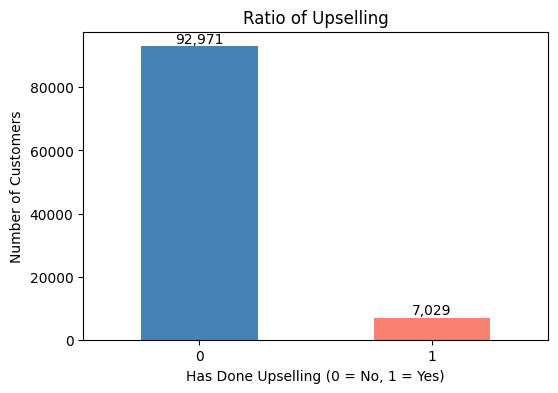

In [14]:
# have a look at the target
import matplotlib.pyplot as plt



display(core_df['has_done_upselling'].value_counts(normalize=True))

# # Target ratio 
# plt.figure(figsize=(6,4))
# core_df['has_done_upselling'].value_counts().plot(kind='bar')
# plt.title("Target Ratio of Upselling")
# plt.xlabel("Has Done Upselling 0/1")
# plt.ylabel("Number of Customers")
# plt.xticks(rotation=0)
# plt.show()

# Target ratio 
plt.figure(figsize=(6,4))
ax = core_df['has_done_upselling'].value_counts().plot(
    kind='bar',
    color=['steelblue', 'salmon']
)

plt.title("Ratio of Upselling")
plt.xlabel("Has Done Upselling (0 = No, 1 = Yes)")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height()):,}',               # format with commas
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom', fontsize=10
    )

plt.show()


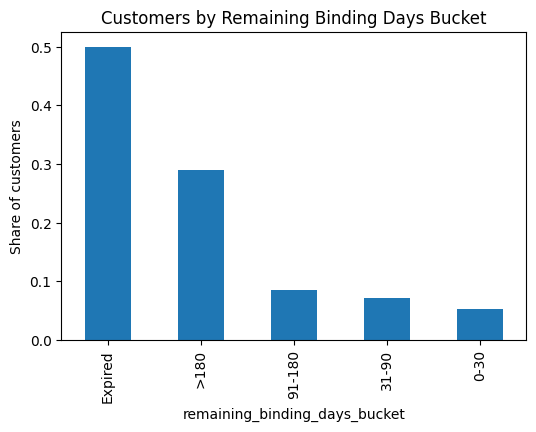

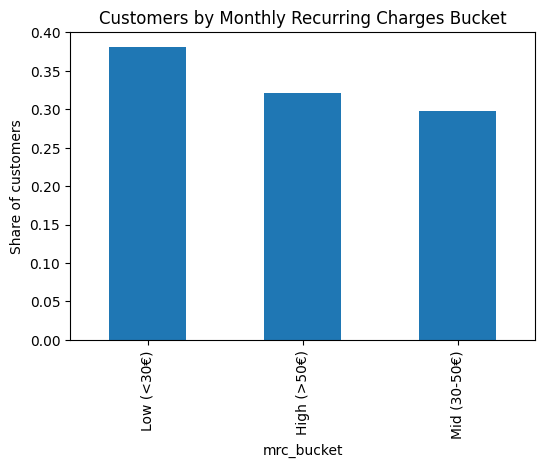

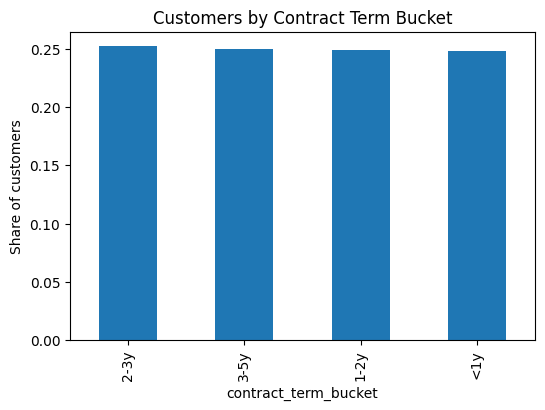

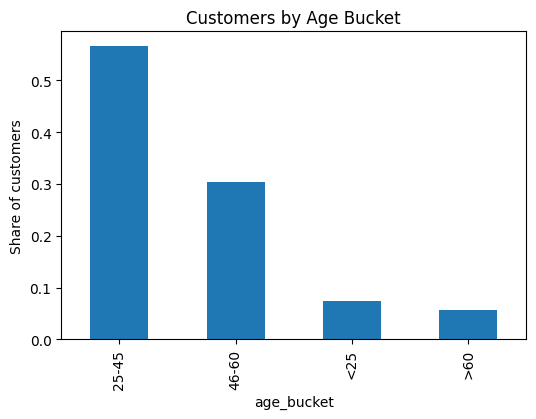

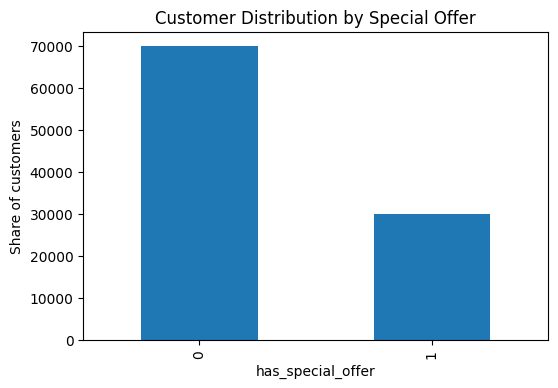

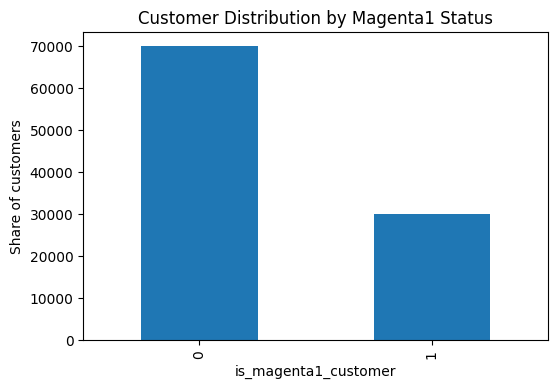

In [15]:
# Make buckets for the model and plots

import matplotlib.pyplot as plt
# binding
remaining_binding_days_bins   = [-1000, -1, 30, 90, 180, 1000]
remaining_binding_days_labels = ["Expired", "0-30", "31-90", "91-180", ">180"]
core_df["remaining_binding_days_bucket"] = pd.cut(core_df["remaining_binding_days"], bins=remaining_binding_days_bins, labels=remaining_binding_days_labels)

plt.figure(figsize=(6,4))
core_df["remaining_binding_days_bucket"].value_counts(normalize=True).plot(kind="bar")
plt.title("Customers by Remaining Binding Days Bucket")
plt.ylabel("Share of customers")
plt.show()

# MRC 
mrc_bins   = [0, 30, 50, 70]
mrc_labels = ["Low (<30€)", "Mid (30-50€)", "High (>50€)"]
core_df["mrc_bucket"] = pd.cut(core_df["gross_mrc"], bins=mrc_bins, labels=mrc_labels)

plt.figure(figsize=(6,4))
core_df["mrc_bucket"].value_counts(normalize=True).plot(kind="bar")
plt.title("Customers by Monthly Recurring Charges Bucket")
plt.ylabel("Share of customers")
plt.show()

# contract term
term_bins   = [0, 365, 730, 1095, 1825]
term_labels = ["<1y", "1-2y", "2-3y", "3-5y"]
core_df["contract_term_bucket"] = pd.cut(core_df["contract_lifetime_days"], bins=term_bins, labels=term_labels)

plt.figure(figsize=(6,4))
core_df["contract_term_bucket"].value_counts(normalize=True).plot(kind="bar")
plt.title("Customers by Contract Term Bucket")
plt.ylabel("Share of customers")
plt.show()

# age
age_bins   = [0, 25, 46, 61, 100] # dont take 40 as cut point bad idea
age_labels = ["<25", "25-45", "46-60", ">60"]
core_df["age_bucket"] = pd.cut(core_df["age"], bins=age_bins, labels=age_labels)

plt.figure(figsize=(6,4))
core_df["age_bucket"].value_counts(normalize=True).plot(kind="bar")
plt.title("Customers by Age Bucket")
plt.ylabel("Share of customers")
plt.show()


# has_special_offer 
plt.figure(figsize=(6,4))
core_df['has_special_offer'].value_counts().plot(kind='bar')
plt.title("Customer Distribution by Special Offer")
plt.ylabel("Share of customers")
plt.show()

# is_magenta1_customer bucket
plt.figure(figsize=(6,4))
core_df['is_magenta1_customer'].value_counts().plot(kind='bar')
plt.title("Customer Distribution by Magenta1 Status")
plt.ylabel("Share of customers")
plt.show()



In [16]:
core_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
rating_account_id,100000.0,NaN,NaN,NaN,549923.19254,259448.704638,100034.0,325124.75,549393.0,774245.75,999999.0
customer_id,100000,58556,4.855982,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,100000.0,NaN,NaN,NaN,43.86915,13.761251,18.0,36.0,43.0,49.0,100.0
contract_lifetime_days,100000.0,NaN,NaN,NaN,778.79252,490.852212,7.0,368.0,734.0,1095.25,1825.0
remaining_binding_days,100000.0,NaN,NaN,NaN,-1.49323,344.961075,-730.0,-236.0,-1.0,231.0,730.0
has_special_offer,100000.0,NaN,NaN,NaN,0.30017,0.458334,0.0,0.0,0.0,1.0,1.0
is_magenta1_customer,100000.0,NaN,NaN,NaN,0.30063,0.458534,0.0,0.0,0.0,1.0,1.0
available_gb,100000.0,NaN,NaN,NaN,24.2424,15.903917,0.0,10.0,20.0,40.0,50.0
gross_mrc,100000.0,NaN,NaN,NaN,37.502475,19.175212,5.0,20.92,38.16,54.08,70.0
smartphone_brand,100000,5,iPhone,39751,NaN,NaN,NaN,NaN,NaN,NaN,NaN


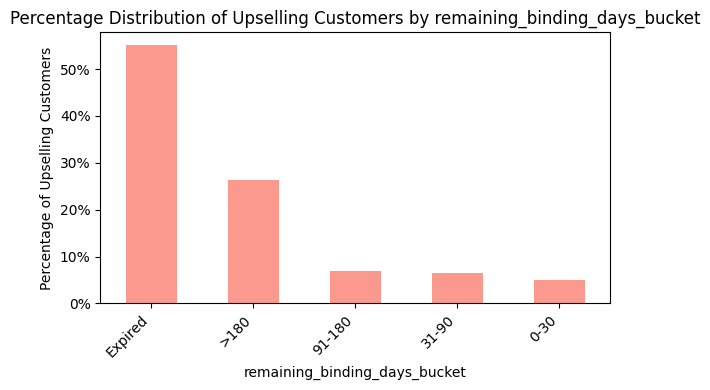

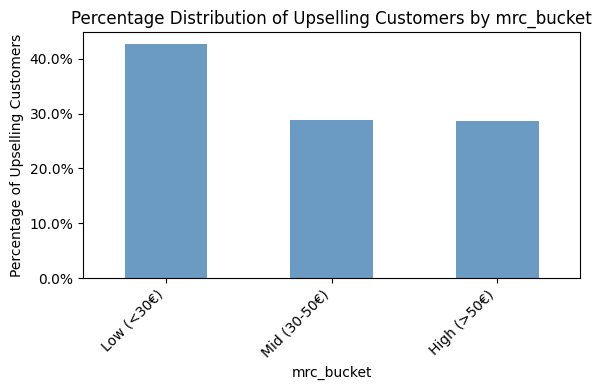

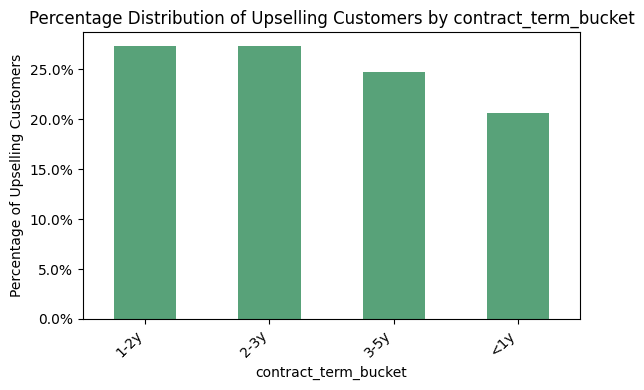

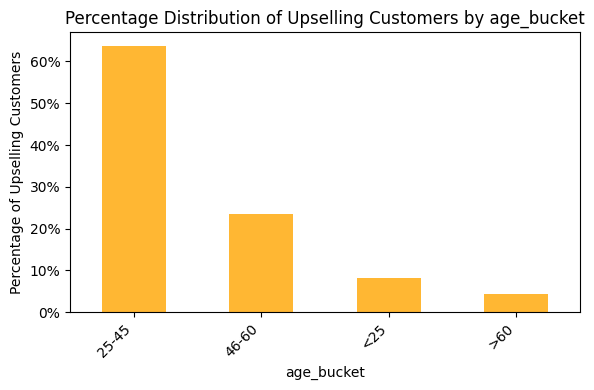

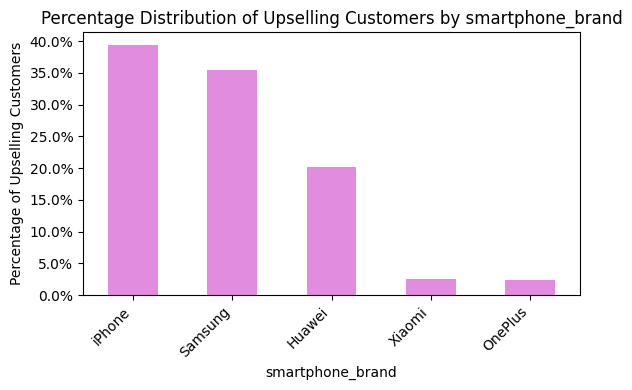

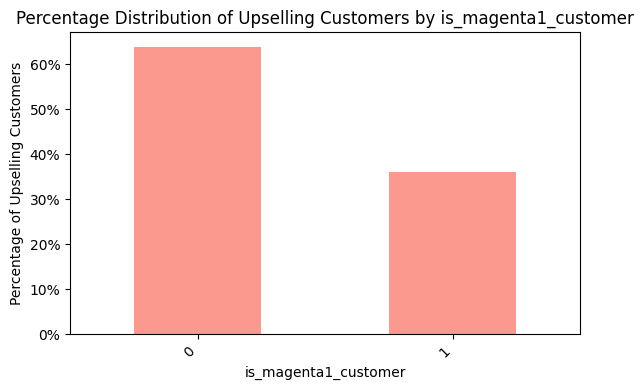

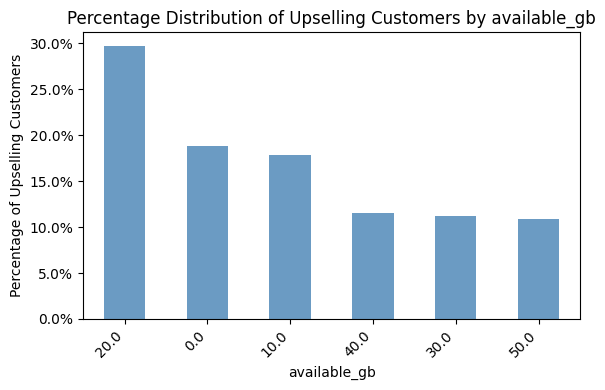

In [17]:

from matplotlib.ticker import PercentFormatter



cols_to_plot = [
    "remaining_binding_days_bucket",
    "mrc_bucket",
    "contract_term_bucket",
    "age_bucket",
    "smartphone_brand",
    "is_magenta1_customer",
    "available_gb"
    
]

colors = ["salmon", "steelblue", "seagreen", "orange", "orchid"]

for i, col in enumerate(cols_to_plot):
    plt.figure(figsize=(6,4))
    
    core_df[core_df['has_done_upselling'] == 1][col].value_counts(normalize=True).plot(
        kind="bar",
        color=colors[i % len(colors)],
        alpha=0.8
    )
    
    plt.title(f"Percentage Distribution of Upselling Customers by {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage of Upselling Customers")
    plt.xticks(rotation=45, ha="right")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    
    plt.tight_layout()
    plt.show()

In [18]:
core_df.age_bucket

0        25-45
1        46-60
2        25-45
3          <25
4        25-45
         ...  
99995      >60
99996      >60
99997      >60
99998      >60
99999      >60
Name: age_bucket, Length: 100000, dtype: category
Categories (4, object): ['<25' < '25-45' < '46-60' < '>60']

In [19]:
# One-hot encode categorical variables for modeling

cat_cols = [
    "remaining_binding_days_bucket",
    "mrc_bucket",
    "contract_term_bucket",
    "age_bucket",
    "smartphone_brand"  
]
cat_feats = pd.get_dummies(core_df[cat_cols], drop_first=True, dtype=int) if cat_cols else pd.DataFrame(index=core_df.index)

core_df = pd.concat([core_df, cat_feats], axis=1)

core_df.info()
cat_feats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 33 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   rating_account_id                     100000 non-null  int64   
 1   customer_id                           100000 non-null  object  
 2   age                                   100000 non-null  int64   
 3   contract_lifetime_days                100000 non-null  int64   
 4   remaining_binding_days                100000 non-null  int64   
 5   has_special_offer                     100000 non-null  int64   
 6   is_magenta1_customer                  100000 non-null  int64   
 7   available_gb                          100000 non-null  float64 
 8   gross_mrc                             100000 non-null  float64 
 9   smartphone_brand                      100000 non-null  category
 10  has_done_upselling                    100000 non-null  in

,remaining_binding_days_bucket_0-30,remaining_binding_days_bucket_31-90,remaining_binding_days_bucket_91-180,remaining_binding_days_bucket_>180,mrc_bucket_Mid (30-50€),mrc_bucket_High (>50€),contract_term_bucket_1-2y,contract_term_bucket_2-3y,contract_term_bucket_3-5y,age_bucket_25-45,age_bucket_46-60,age_bucket_>60,smartphone_brand_OnePlus,smartphone_brand_Samsung,smartphone_brand_Xiaomi,smartphone_brand_iPhone
0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0
1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1
99996,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0
99997,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0
99998,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [20]:
# Quick check feature interactions

features_to_check = ['is_magenta1_customer', 'has_special_offer', 'mrc_bucket', 'remaining_binding_days_bucket', 'contract_term_bucket', 'age_bucket']

for feature in features_to_check:
    print(f"Feature: {feature} vs target")
    ct = pd.crosstab(core_df[feature], core_df['has_done_upselling'], normalize='index')
    display(ct)

Feature: is_magenta1_customer vs target


has_done_upselling,0,1
is_magenta1_customer,,
0,0.935742,0.064258
1,0.915677,0.084323


Feature: has_special_offer vs target


has_done_upselling,0,1
has_special_offer,,
0,0.928597,0.071403
1,0.932305,0.067695


Feature: mrc_bucket vs target


has_done_upselling,0,1
mrc_bucket,,
Low (<30€),0.921334,0.078666
Mid (30-50€),0.932023,0.067977
High (>50€),0.937508,0.062492


Feature: remaining_binding_days_bucket vs target


has_done_upselling,0,1
remaining_binding_days_bucket,,
Expired,0.922628,0.077372
0-30,0.934304,0.065696
31-90,0.935828,0.064172
91-180,0.942242,0.057758
>180,0.935923,0.064077


Feature: contract_term_bucket vs target


has_done_upselling,0,1
contract_term_bucket,,
<1y,0.941627,0.058373
1-2y,0.922944,0.077056
2-3y,0.923833,0.076167
3-5y,0.930560,0.069440


Feature: age_bucket vs target


has_done_upselling,0,1
age_bucket,,
<25,0.921648,0.078352
25-45,0.920825,0.079175
46-60,0.945470,0.054530
>60,0.944553,0.055447


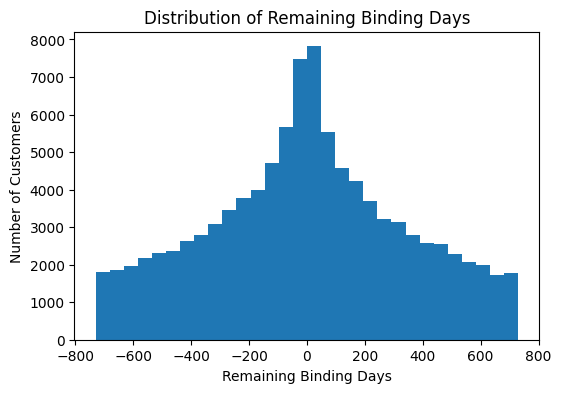

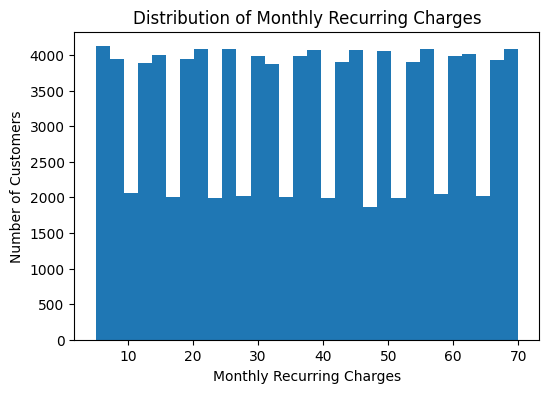

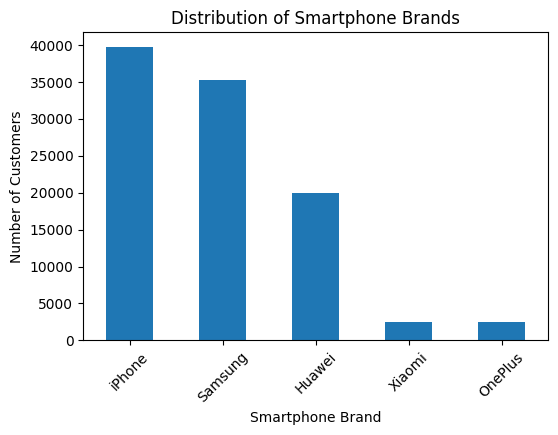

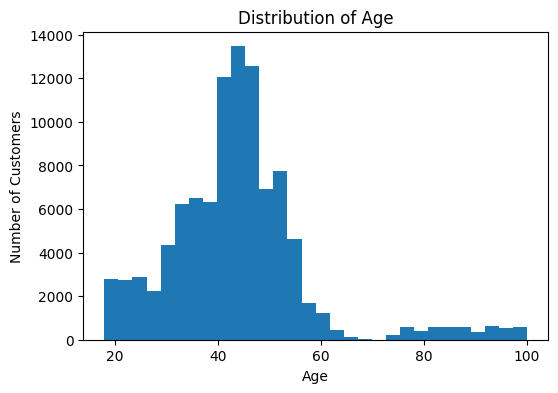

In [21]:
# look at some distribution without buckets to see if any noticable things


# remaining days distribution
plt.figure(figsize=(6,4))
core_df['remaining_binding_days'].plot(kind='hist', bins=30)
plt.title("Distribution of Remaining Binding Days")
plt.xlabel("Remaining Binding Days")
plt.ylabel("Number of Customers")
plt.show()

# monthly recurring charges distribution
plt.figure(figsize=(6,4))
core_df['gross_mrc'].plot(kind='hist', bins=30)
plt.title("Distribution of Monthly Recurring Charges")
plt.xlabel("Monthly Recurring Charges")
plt.ylabel("Number of Customers")
plt.show()

# smartphone brand distribution
plt.figure(figsize=(6,4))
core_df['smartphone_brand'].value_counts().plot(kind='bar')
plt.title("Distribution of Smartphone Brands")
plt.xlabel("Smartphone Brand")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()

# age distribution
plt.figure(figsize=(6,4))
core_df['age'].plot(kind='hist', bins=30)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.show()

In [22]:
# sanity check
#get the processed core data from src
dir = "../tmpn7u6ipx6/storage/"
processed_core_data = load_artifact("processed_core_data")
# check the consistency
core_df.shape, processed_core_data.shape

((100000, 33), (100000, 33))

In [23]:
# Think about the label how to contract a new one?
# has_done_upselling could be reframed to a future-looking target (e.g., upsell within the next X months) to align with campaign timing
# it recognizes current state, not future behavior. Better target would be just before upselling

df = core_df.copy()
# for each customer, compute if they ever go from 0 to 1
df_sorted = df.sort_values(["customer_id", "contract_lifetime_days"])  # ensure time order
df_sorted["shifted"] = df_sorted.groupby("customer_id")["has_done_upselling"].shift()

# detect transitions from 0 -> 1
df_sorted["transition_0_to_1"] = (df_sorted["shifted"] == 0) & (df_sorted["has_done_upselling"] == 1)

# mark per customer if such a transition exists
customer_transition = df_sorted.groupby("customer_id")["transition_0_to_1"].any().reset_index()

customer_transition.rename(columns={"transition_0_to_1": "has_transition_0_to_1"}, inplace=True)

customer_transition.has_transition_0_to_1.value_counts()

has_transition_0_to_1
False    55822
True      2734
Name: count, dtype: int64

In [24]:
comparision = customer_transition.merge(core_df[['rating_account_id','customer_id','age','contract_lifetime_days','remaining_binding_days','has_special_offer','is_magenta1_customer', 'has_done_upselling']], on="customer_id", how="right")

cus_list= comparision[comparision.has_transition_0_to_1].customer_id.to_list()

core_df[['rating_account_id','customer_id','age',
         'contract_lifetime_days','remaining_binding_days','has_special_offer','is_magenta1_customer', 
         'has_done_upselling']][core_df.customer_id.isin(cus_list)].sort_values('customer_id')

,rating_account_id,customer_id,age,contract_lifetime_days,remaining_binding_days,has_special_offer,is_magenta1_customer,has_done_upselling
23721,167889,1.103539,46,802,-636,0,0,0
88009,220633,1.103539,30,1800,586,0,1,1
37191,332393,1.106464,40,718,608,0,0,0
76994,148691,1.106464,46,1651,279,1,0,0
42737,590883,1.106464,56,1056,-561,0,1,0
...,...,...,...,...,...,...,...,...
58539,477058,5.993954,43,84,76,0,0,0
50623,614588,5.993954,44,722,-547,0,0,1
60512,352475,5.995090,44,62,-28,0,0,0
83893,743488,5.995090,30,1729,244,1,1,1


In [25]:
# aggregate usage with minimal feature engineering

agg_usage = usage_df.groupby("rating_account_id").agg(
    total_used_gb=('used_gb', 'sum'),
    avg_used_gb=('used_gb', 'mean'),
    std_used_gb=('used_gb', 'std'),
    min_used_gb=('used_gb', 'min'),
    max_used_gb=('used_gb', 'max'),
    usage_month_count=('billed_period_month_d', 'count'),# make sure max 4
    roaming_months=('has_used_roaming', 'sum'),
).reset_index()

# is there an increase in usage?
difference = usage_df.sort_values(by=['rating_account_id', 'billed_period_month_d']).groupby('rating_account_id')['used_gb'].agg(['first','last']).reset_index()
difference['usage_increase'] = (difference['last'] > difference['first']).astype(int)
difference["usage_trend"] = difference["last"] - difference["first"]

# roaming  
agg_usage["roaming_ratio"] = agg_usage["roaming_months"] / agg_usage["usage_month_count"]
agg_usage["had_roaming"] = (agg_usage["roaming_months"] > 0).astype(int)

agg_usage = agg_usage.merge(difference[['rating_account_id', 'usage_increase','usage_trend']], on='rating_account_id', how='left')

display(agg_usage.head())
display(agg_usage.describe())
agg_usage.info()

,rating_account_id,total_used_gb,avg_used_gb,std_used_gb,min_used_gb,max_used_gb,usage_month_count,roaming_months,roaming_ratio,had_roaming,usage_increase,usage_trend
0,100034,32.4,8.100,2.210581,5.1,10.3,4,1,0.25,1,1,2.9
1,100036,130.3,32.575,11.135940,19.0,45.5,4,1,0.25,1,1,15.8
2,100039,32.2,8.050,2.266422,5.1,10.6,4,0,0.00,0,1,3.4
3,100046,47.5,11.875,2.136001,9.9,14.7,4,2,0.50,1,0,-4.1
4,100051,181.5,45.375,20.504857,26.8,67.5,4,1,0.25,1,1,38.4


,rating_account_id,total_used_gb,avg_used_gb,std_used_gb,min_used_gb,max_used_gb,usage_month_count,roaming_months,roaming_ratio,had_roaming,usage_increase,usage_trend
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,549923.192540,55.935902,13.983975,4.783819,8.742596,19.247183,4.0,1.202970,0.300743,0.761440,0.48541,0.027924
std,259448.704638,69.105486,17.276371,6.527254,11.241966,23.814069,0.0,0.916614,0.229154,0.426205,0.49979,11.422510
min,100034.000000,0.100000,0.025000,0.000000,0.000000,0.100000,4.0,0.000000,0.000000,0.000000,0.00000,-54.400000
25%,325124.750000,4.350000,1.087500,0.424264,0.975000,1.225000,4.0,1.000000,0.250000,1.000000,0.00000,-1.600000
50%,549393.000000,20.750000,5.187500,1.541644,4.800000,5.400000,4.0,1.000000,0.250000,1.000000,0.00000,0.000000
75%,774245.750000,61.625000,15.406250,4.420878,14.550000,16.400000,4.0,2.000000,0.500000,1.000000,1.00000,1.600000
max,999999.000000,265.700000,66.425000,29.643324,64.800000,70.000000,4.0,4.000000,1.000000,1.000000,1.00000,54.600000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating_account_id  100000 non-null  int64  
 1   total_used_gb      100000 non-null  float64
 2   avg_used_gb        100000 non-null  float64
 3   std_used_gb        100000 non-null  float64
 4   min_used_gb        100000 non-null  float64
 5   max_used_gb        100000 non-null  float64
 6   usage_month_count  100000 non-null  int64  
 7   roaming_months     100000 non-null  int64  
 8   roaming_ratio      100000 non-null  float64
 9   had_roaming        100000 non-null  int64  
 10  usage_increase     100000 non-null  int64  
 11  usage_trend        100000 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 9.2 MB


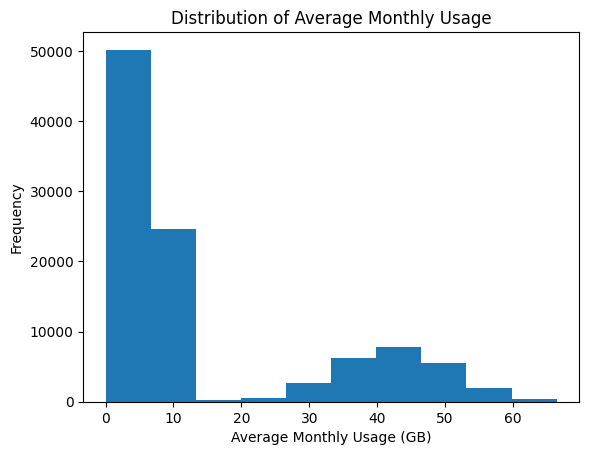

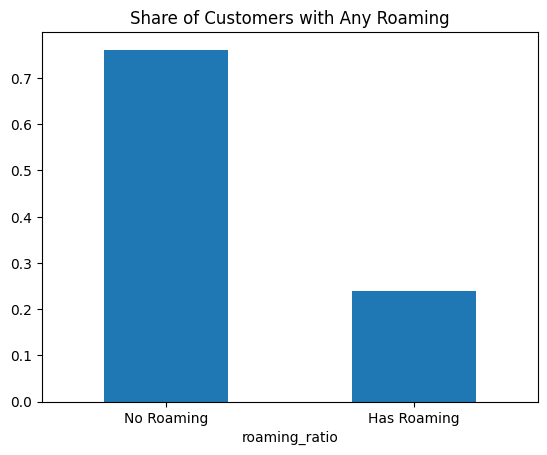

In [26]:
# average usage
agg_usage['avg_used_gb'].plot(kind='hist', bins=10)
plt.title("Distribution of Average Monthly Usage")
plt.xlabel("Average Monthly Usage (GB)")
plt.show()

# roaming usage
# Share of customers with any roaming
(agg_usage["roaming_ratio"] > 0).value_counts(normalize=True).plot(kind="bar")
plt.title("Share of Customers with Any Roaming")
plt.xticks([0,1], ["No Roaming", "Has Roaming"], rotation=0)
plt.show()

In [27]:
# sanity check
#get the processed core data from src
dir = "../tmpn7u6ipx6/storage/"
agg_processed_usage_data = load_artifact("agg_processed_usage_info")
# check the consistency
agg_usage.shape, agg_processed_usage_data.shape

((100000, 12), (100000, 12))

In [28]:

interactions_df.head()

,customer_id,type_subtype,n,days_since_last
0,3.592423,produkte&services-tarifdetails,2,75
1,3.592423,produkte&services-tarifwechsel,1,162
2,1.347316,prolongation,2,86
3,5.686529,produkte&services-tarifdetails,1,171
4,5.702062,produkte&services-tarifdetails,1,49


In [29]:
# type of interaction make sure 4 unique values

prolongations = (
    interactions_df[interactions_df["type_subtype"].str.contains("prolongation", case=False, na=False)]
    .groupby("customer_id")["n"]
    .sum()
    .rename("interact_prolongations")
)

tarifdetails = (
    interactions_df[interactions_df["type_subtype"].str.contains("tarifdetails", case=False, na=False)]
    .groupby("customer_id")["n"]
    .sum()
    .rename("interact_tarifdetails")
    )

tarifwechsel = (
    interactions_df[interactions_df["type_subtype"].str.contains("tarifwechsel", case=False, na=False)]
    .groupby("customer_id")["n"]
    .sum()  
    .rename("interact_tarifwechsel")
    )

rechnungsanfragen = (
    interactions_df[interactions_df["type_subtype"].str.contains("rechnungsanfragen", case=False, na=False)]
    .groupby("customer_id")["n"]
    .sum()
    .rename("interact_rechnungsanfragen")
    )

# how many interactions per customer?
interactions_per_customer = interactions_df.groupby('customer_id')['n'].sum().rename('num_interactions').astype(int)

# how many types of interaction per customer?
unique_interactions_per_customer = interactions_df.groupby('customer_id')['type_subtype'].nunique().rename('num_unique_interactions').astype(int)

# how recent was the last interaction?
recency = interactions_df.groupby('customer_id')['days_since_last'].min().rename('recency').astype(int)

# Merge features together
agg_inter = pd.concat([interactions_per_customer, unique_interactions_per_customer, recency, prolongations, tarifdetails, tarifwechsel, rechnungsanfragen], axis=1).fillna(0).reset_index()

agg_inter.head()
agg_inter.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42096 entries, 0 to 42095
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 42096 non-null  object 
 1   num_interactions            42096 non-null  int64  
 2   num_unique_interactions     42096 non-null  int64  
 3   recency                     42096 non-null  int64  
 4   interact_prolongations      42096 non-null  float64
 5   interact_tarifdetails       42096 non-null  float64
 6   interact_tarifwechsel       42096 non-null  float64
 7   interact_rechnungsanfragen  42096 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 2.6+ MB


In [30]:
agg_inter.head()

,customer_id,num_interactions,num_unique_interactions,recency,interact_prolongations,interact_tarifdetails,interact_tarifwechsel,interact_rechnungsanfragen
0,1.100079,3,1,108,0.0,0.0,0.0,3.0
1,1.100081,9,2,71,0.0,3.0,0.0,6.0
2,1.100353,1,1,105,0.0,1.0,0.0,0.0
3,1.100424,2,1,149,2.0,0.0,0.0,0.0
4,1.100499,3,1,6,0.0,0.0,3.0,0.0


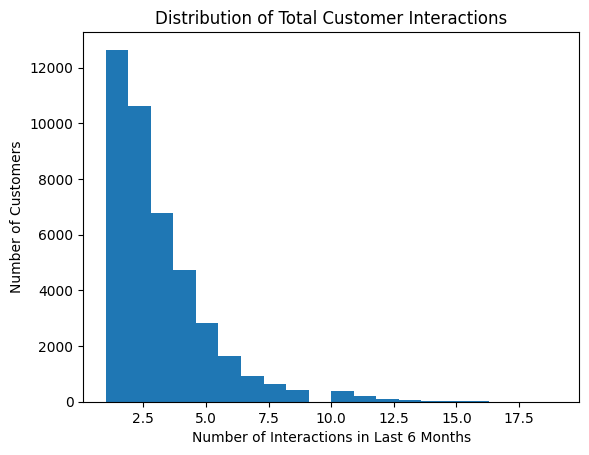

In [31]:

# interaction share

agg_inter['num_interactions'].plot(kind='hist', bins=20)
plt.title("Distribution of Total Customer Interactions")
plt.xlabel("Number of Interactions in Last 6 Months")
plt.ylabel("Number of Customers")
plt.show()

In [32]:
# sanity check
#get the processed core data from src
dir = "../tmpn7u6ipx6/storage/"
agg_processed_usage_data = load_artifact("agg_processed_customer_interactions")
# check the consistency
agg_inter.shape, agg_processed_usage_data.shape

((42096, 8), (42107, 8))

In [33]:
# Final merge
# We have:
# core_data_clean - contract info + demographics + target
# agg_usage - usage features (avg, max, roaming, trend...)
# agg_inter - interactions features (total, complaints, flags...)

display(core_df.describe(include='all').T)
display(agg_usage.describe(include='all').T)
display(agg_inter.describe(include='all').T)

core_df.info()
agg_usage.info()
agg_inter.info()

display(core_df.head())
display(agg_usage.head())
display(agg_inter.head())


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
rating_account_id,100000.0,NaN,NaN,NaN,549923.19254,259448.704638,100034.0,325124.75,549393.0,774245.75,999999.0
customer_id,100000,58556,4.855982,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,100000.0,NaN,NaN,NaN,43.86915,13.761251,18.0,36.0,43.0,49.0,100.0
contract_lifetime_days,100000.0,NaN,NaN,NaN,778.79252,490.852212,7.0,368.0,734.0,1095.25,1825.0
remaining_binding_days,100000.0,NaN,NaN,NaN,-1.49323,344.961075,-730.0,-236.0,-1.0,231.0,730.0
has_special_offer,100000.0,NaN,NaN,NaN,0.30017,0.458334,0.0,0.0,0.0,1.0,1.0
is_magenta1_customer,100000.0,NaN,NaN,NaN,0.30063,0.458534,0.0,0.0,0.0,1.0,1.0
available_gb,100000.0,NaN,NaN,NaN,24.2424,15.903917,0.0,10.0,20.0,40.0,50.0
gross_mrc,100000.0,NaN,NaN,NaN,37.502475,19.175212,5.0,20.92,38.16,54.08,70.0
smartphone_brand,100000,5,iPhone,39751,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,mean,std,min,25%,50%,75%,max
rating_account_id,100000.0,549923.192540,259448.704638,100034.000,325124.750000,549393.000000,774245.750000,999999.000000
total_used_gb,100000.0,55.935902,69.105486,0.100,4.350000,20.750000,61.625000,265.700000
avg_used_gb,100000.0,13.983975,17.276371,0.025,1.087500,5.187500,15.406250,66.425000
std_used_gb,100000.0,4.783819,6.527254,0.000,0.424264,1.541644,4.420878,29.643324
min_used_gb,100000.0,8.742596,11.241966,0.000,0.975000,4.800000,14.550000,64.800000
max_used_gb,100000.0,19.247183,23.814069,0.100,1.225000,5.400000,16.400000,70.000000
usage_month_count,100000.0,4.000000,0.000000,4.000,4.000000,4.000000,4.000000,4.000000
roaming_months,100000.0,1.202970,0.916614,0.000,1.000000,1.000000,2.000000,4.000000
roaming_ratio,100000.0,0.300743,0.229154,0.000,0.250000,0.250000,0.500000,1.000000
had_roaming,100000.0,0.761440,0.426205,0.000,1.000000,1.000000,1.000000,1.000000


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,42096,42096,5.999980,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_interactions,42096.0,NaN,NaN,NaN,2.901345,2.168292,1.0,1.0,2.0,4.0,19.0
num_unique_interactions,42096.0,NaN,NaN,NaN,1.500879,0.672045,1.0,1.0,1.0,2.0,3.0
recency,42096.0,NaN,NaN,NaN,76.380107,50.99921,0.0,32.0,70.0,117.0,180.0
interact_prolongations,42096.0,NaN,NaN,NaN,0.733823,1.285039,0.0,0.0,0.0,1.0,10.0
interact_tarifdetails,42096.0,NaN,NaN,NaN,0.731138,1.290228,0.0,0.0,0.0,1.0,10.0
interact_tarifwechsel,42096.0,NaN,NaN,NaN,0.717598,1.263002,0.0,0.0,0.0,1.0,10.0
interact_rechnungsanfragen,42096.0,NaN,NaN,NaN,0.718786,1.262269,0.0,0.0,0.0,1.0,10.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 33 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   rating_account_id                     100000 non-null  int64   
 1   customer_id                           100000 non-null  object  
 2   age                                   100000 non-null  int64   
 3   contract_lifetime_days                100000 non-null  int64   
 4   remaining_binding_days                100000 non-null  int64   
 5   has_special_offer                     100000 non-null  int64   
 6   is_magenta1_customer                  100000 non-null  int64   
 7   available_gb                          100000 non-null  float64 
 8   gross_mrc                             100000 non-null  float64 
 9   smartphone_brand                      100000 non-null  category
 10  has_done_upselling                    100000 non-null  in

,rating_account_id,customer_id,age,contract_lifetime_days,remaining_binding_days,has_special_offer,is_magenta1_customer,available_gb,gross_mrc,smartphone_brand,...,contract_term_bucket_1-2y,contract_term_bucket_2-3y,contract_term_bucket_3-5y,age_bucket_25-45,age_bucket_46-60,age_bucket_>60,smartphone_brand_OnePlus,smartphone_brand_Samsung,smartphone_brand_Xiaomi,smartphone_brand_iPhone
0,278788,5.200192,42,958,137,0,0,40.0,55.41,Samsung,...,0,1,0,1,0,0,0,1,0,0
1,638234,5.127164,48,73,68,0,0,30.0,51.43,iPhone,...,0,0,0,0,1,0,0,0,0,1
2,937207,4.605381,34,612,224,1,0,30.0,38.16,Samsung,...,1,0,0,1,0,0,0,1,0,0
3,172992,1.609815,25,251,-70,1,0,10.0,66.02,Samsung,...,0,0,0,0,0,0,0,1,0,0
4,420234,3.226236,40,825,594,1,0,20.0,18.27,iPhone,...,0,1,0,1,0,0,0,0,0,1


,rating_account_id,total_used_gb,avg_used_gb,std_used_gb,min_used_gb,max_used_gb,usage_month_count,roaming_months,roaming_ratio,had_roaming,usage_increase,usage_trend
0,100034,32.4,8.100,2.210581,5.1,10.3,4,1,0.25,1,1,2.9
1,100036,130.3,32.575,11.135940,19.0,45.5,4,1,0.25,1,1,15.8
2,100039,32.2,8.050,2.266422,5.1,10.6,4,0,0.00,0,1,3.4
3,100046,47.5,11.875,2.136001,9.9,14.7,4,2,0.50,1,0,-4.1
4,100051,181.5,45.375,20.504857,26.8,67.5,4,1,0.25,1,1,38.4


,customer_id,num_interactions,num_unique_interactions,recency,interact_prolongations,interact_tarifdetails,interact_tarifwechsel,interact_rechnungsanfragen
0,1.100079,3,1,108,0.0,0.0,0.0,3.0
1,1.100081,9,2,71,0.0,3.0,0.0,6.0
2,1.100353,1,1,105,0.0,1.0,0.0,0.0
3,1.100424,2,1,149,2.0,0.0,0.0,0.0
4,1.100499,3,1,6,0.0,0.0,3.0,0.0


In [34]:

merged = (
    core_df
    .merge(agg_usage, on="rating_account_id", how="left")
    .merge(agg_inter, on="customer_id", how="left")
)

print("Merged shape:", merged.shape)
display(merged.head())
merged.info(verbose=True)
display(merged.describe(include='all').T)




Merged shape: (100000, 51)


,rating_account_id,customer_id,age,contract_lifetime_days,remaining_binding_days,has_special_offer,is_magenta1_customer,available_gb,gross_mrc,smartphone_brand,...,had_roaming,usage_increase,usage_trend,num_interactions,num_unique_interactions,recency,interact_prolongations,interact_tarifdetails,interact_tarifwechsel,interact_rechnungsanfragen
0,278788,5.200192,42,958,137,0,0,40.0,55.41,Samsung,...,1,1,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,638234,5.127164,48,73,68,0,0,30.0,51.43,iPhone,...,1,0,-0.6,10.0,3.0,59.0,4.0,4.0,2.0,0.0
2,937207,4.605381,34,612,224,1,0,30.0,38.16,Samsung,...,1,1,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,172992,1.609815,25,251,-70,1,0,10.0,66.02,Samsung,...,0,1,0.2,4.0,1.0,172.0,0.0,4.0,0.0,0.0
4,420234,3.226236,40,825,594,1,0,20.0,18.27,iPhone,...,1,0,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 51 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   rating_account_id                     100000 non-null  int64   
 1   customer_id                           100000 non-null  object  
 2   age                                   100000 non-null  int64   
 3   contract_lifetime_days                100000 non-null  int64   
 4   remaining_binding_days                100000 non-null  int64   
 5   has_special_offer                     100000 non-null  int64   
 6   is_magenta1_customer                  100000 non-null  int64   
 7   available_gb                          100000 non-null  float64 
 8   gross_mrc                             100000 non-null  float64 
 9   smartphone_brand                      100000 non-null  category
 10  has_done_upselling                    100000 non-null  in

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
rating_account_id,100000.0,NaN,NaN,NaN,549923.19254,259448.704638,100034.0,325124.75,549393.0,774245.75,999999.0
customer_id,100000,58556,4.855982,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,100000.0,NaN,NaN,NaN,43.86915,13.761251,18.0,36.0,43.0,49.0,100.0
contract_lifetime_days,100000.0,NaN,NaN,NaN,778.79252,490.852212,7.0,368.0,734.0,1095.25,1825.0
remaining_binding_days,100000.0,NaN,NaN,NaN,-1.49323,344.961075,-730.0,-236.0,-1.0,231.0,730.0
has_special_offer,100000.0,NaN,NaN,NaN,0.30017,0.458334,0.0,0.0,0.0,1.0,1.0
is_magenta1_customer,100000.0,NaN,NaN,NaN,0.30063,0.458534,0.0,0.0,0.0,1.0,1.0
available_gb,100000.0,NaN,NaN,NaN,24.2424,15.903917,0.0,10.0,20.0,40.0,50.0
gross_mrc,100000.0,NaN,NaN,NaN,37.502475,19.175212,5.0,20.92,38.16,54.08,70.0
smartphone_brand,100000,5,iPhone,39751,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# some Interactions nan as discussed earlier 

fill_zero_cols = [
    "num_interactions", "num_unique_interactions","interact_prolongations",
    "interact_tarifdetails","interact_tarifwechsel","interact_rechnungsanfragen"
]
for c in fill_zero_cols:
    if c in merged.columns:
        merged[c] = merged[c].fillna(0).astype(int)

# for recency 0 does not make sense
# filled with a large number
merged["recency"] = merged["recency"].fillna(999).astype(int)

data = merged.copy()


In [36]:
# sanity check
#get the processed core data from src
dir = "../tmpn7u6ipx6/storage/"
processed_and_merged_data = load_artifact("processed_and_merged_data")
# check the consistency
data.shape, processed_and_merged_data.shape

((100000, 51), (100000, 51))

In [37]:
# Modeling
display(data.columns)
data.info()
display(data.head())

Index(['rating_account_id', 'customer_id', 'age', 'contract_lifetime_days',
       'remaining_binding_days', 'has_special_offer', 'is_magenta1_customer',
       'available_gb', 'gross_mrc', 'smartphone_brand', 'has_done_upselling',
       'available_gb_missing', 'is_premium_device',
       'remaining_binding_days_bucket', 'mrc_bucket', 'contract_term_bucket',
       'age_bucket', 'remaining_binding_days_bucket_0-30',
       'remaining_binding_days_bucket_31-90',
       'remaining_binding_days_bucket_91-180',
       'remaining_binding_days_bucket_>180', 'mrc_bucket_Mid (30-50€)',
       'mrc_bucket_High (>50€)', 'contract_term_bucket_1-2y',
       'contract_term_bucket_2-3y', 'contract_term_bucket_3-5y',
       'age_bucket_25-45', 'age_bucket_46-60', 'age_bucket_>60',
       'smartphone_brand_OnePlus', 'smartphone_brand_Samsung',
       'smartphone_brand_Xiaomi', 'smartphone_brand_iPhone', 'total_used_gb',
       'avg_used_gb', 'std_used_gb', 'min_used_gb', 'max_used_gb',
       'usage_

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 51 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   rating_account_id                     100000 non-null  int64   
 1   customer_id                           100000 non-null  object  
 2   age                                   100000 non-null  int64   
 3   contract_lifetime_days                100000 non-null  int64   
 4   remaining_binding_days                100000 non-null  int64   
 5   has_special_offer                     100000 non-null  int64   
 6   is_magenta1_customer                  100000 non-null  int64   
 7   available_gb                          100000 non-null  float64 
 8   gross_mrc                             100000 non-null  float64 
 9   smartphone_brand                      100000 non-null  category
 10  has_done_upselling                    100000 non-null  in

,rating_account_id,customer_id,age,contract_lifetime_days,remaining_binding_days,has_special_offer,is_magenta1_customer,available_gb,gross_mrc,smartphone_brand,...,had_roaming,usage_increase,usage_trend,num_interactions,num_unique_interactions,recency,interact_prolongations,interact_tarifdetails,interact_tarifwechsel,interact_rechnungsanfragen
0,278788,5.200192,42,958,137,0,0,40.0,55.41,Samsung,...,1,1,0.4,0,0,999,0,0,0,0
1,638234,5.127164,48,73,68,0,0,30.0,51.43,iPhone,...,1,0,-0.6,10,3,59,4,4,2,0
2,937207,4.605381,34,612,224,1,0,30.0,38.16,Samsung,...,1,1,0.2,0,0,999,0,0,0,0
3,172992,1.609815,25,251,-70,1,0,10.0,66.02,Samsung,...,0,1,0.2,4,1,172,0,4,0,0
4,420234,3.226236,40,825,594,1,0,20.0,18.27,iPhone,...,1,0,-0.6,0,0,999,0,0,0,0


In [38]:
# Train Test Split
# recall that customers can have multiple contracts dont put these customers in the test set
from sklearn.model_selection import StratifiedGroupKFold

# stratification for keeping positive rate across folds
# grouping for avoiding leakage (one customer multiple accounts)
# splits for cross validation
# random state for reproducibility

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42) 

target = data['has_done_upselling']
X = data.drop(columns=['has_done_upselling'])
groups = data['customer_id']

train_idx, test_idx = next(sgkf.split(X, target, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]

# check distribution
print(f"Train positives: {y_train.mean():.3f}, Test positives: {y_test.mean():.3f}")



Train positives: 0.071, Test positives: 0.068


In [39]:
core_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 33 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   rating_account_id                     100000 non-null  int64   
 1   customer_id                           100000 non-null  object  
 2   age                                   100000 non-null  int64   
 3   contract_lifetime_days                100000 non-null  int64   
 4   remaining_binding_days                100000 non-null  int64   
 5   has_special_offer                     100000 non-null  int64   
 6   is_magenta1_customer                  100000 non-null  int64   
 7   available_gb                          100000 non-null  float64 
 8   gross_mrc                             100000 non-null  float64 
 9   smartphone_brand                      100000 non-null  category
 10  has_done_upselling                    100000 non-null  in

In [40]:
# systematically run the subset of features

core_raw = [
    "age", "contract_lifetime_days", "remaining_binding_days", "gross_mrc",
    "available_gb", "available_gb_missing",
    "has_special_offer", "is_magenta1_customer", "is_premium_device",
]

core_with_buckets = ['remaining_binding_days_bucket_0-30',
                    'remaining_binding_days_bucket_31-90',
                    'remaining_binding_days_bucket_91-180',
                    'remaining_binding_days_bucket_>180', 'mrc_bucket_Mid (30-50€)',
                    'mrc_bucket_High (>50€)', 'contract_term_bucket_1-2y',
                    'contract_term_bucket_2-3y', 'contract_term_bucket_3-5y',
                    'age_bucket_25-45', 'age_bucket_46-60', 'age_bucket_>60',
                    "available_gb", "available_gb_missing", "has_special_offer", "is_magenta1_customer", "is_premium_device",]

usage_feature_engineered = [
    "total_used_gb", "avg_used_gb", "std_used_gb", "min_used_gb", "max_used_gb",
    "roaming_months", "roaming_ratio", "had_roaming", "usage_increase", "usage_trend"
]

interaction_feature_engineered = [
    "num_interactions", "num_unique_interactions", "recency",
    "interact_prolongations", "interact_tarifdetails", "interact_tarifwechsel", "interact_rechnungsanfragen"
]

In [41]:
X_train.columns, 

(Index(['rating_account_id', 'customer_id', 'age', 'contract_lifetime_days',
        'remaining_binding_days', 'has_special_offer', 'is_magenta1_customer',
        'available_gb', 'gross_mrc', 'smartphone_brand', 'available_gb_missing',
        'is_premium_device', 'remaining_binding_days_bucket', 'mrc_bucket',
        'contract_term_bucket', 'age_bucket',
        'remaining_binding_days_bucket_0-30',
        'remaining_binding_days_bucket_31-90',
        'remaining_binding_days_bucket_91-180',
        'remaining_binding_days_bucket_>180', 'mrc_bucket_Mid (30-50€)',
        'mrc_bucket_High (>50€)', 'contract_term_bucket_1-2y',
        'contract_term_bucket_2-3y', 'contract_term_bucket_3-5y',
        'age_bucket_25-45', 'age_bucket_46-60', 'age_bucket_>60',
        'smartphone_brand_OnePlus', 'smartphone_brand_Samsung',
        'smartphone_brand_Xiaomi', 'smartphone_brand_iPhone', 'total_used_gb',
        'avg_used_gb', 'std_used_gb', 'min_used_gb', 'max_used_gb',
        'usage_month_



Using features: ['age', 'contract_lifetime_days', 'remaining_binding_days', 'gross_mrc', 'available_gb', 'available_gb_missing', 'has_special_offer', 'is_magenta1_customer', 'is_premium_device']
              precision    recall  f1-score   support

           0      0.937     0.877     0.906     18623
           1      0.104     0.196     0.136      1363

    accuracy                          0.830     19986
   macro avg      0.521     0.536     0.521     19986
weighted avg      0.880     0.830     0.853     19986



Using features: ['remaining_binding_days_bucket_0-30', 'remaining_binding_days_bucket_31-90', 'remaining_binding_days_bucket_91-180', 'remaining_binding_days_bucket_>180', 'mrc_bucket_Mid (30-50€)', 'mrc_bucket_High (>50€)', 'contract_term_bucket_1-2y', 'contract_term_bucket_2-3y', 'contract_term_bucket_3-5y', 'age_bucket_25-45', 'age_bucket_46-60', 'age_bucket_>60', 'available_gb', 'available_gb_missing', 'has_special_offer', 'is_magenta1_customer', 'is_premium_device'

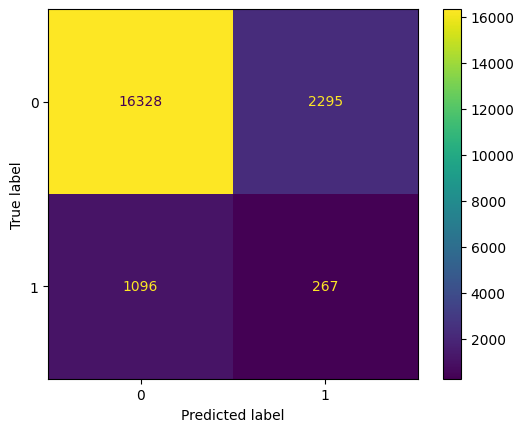

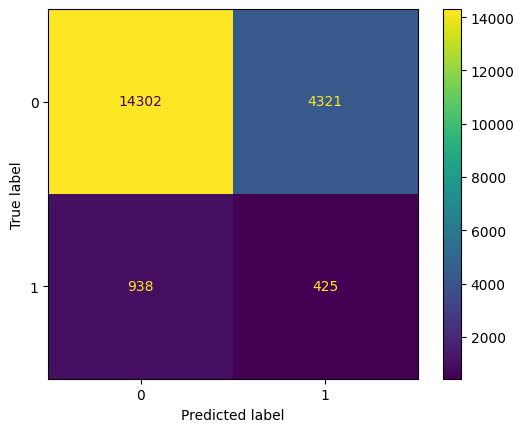

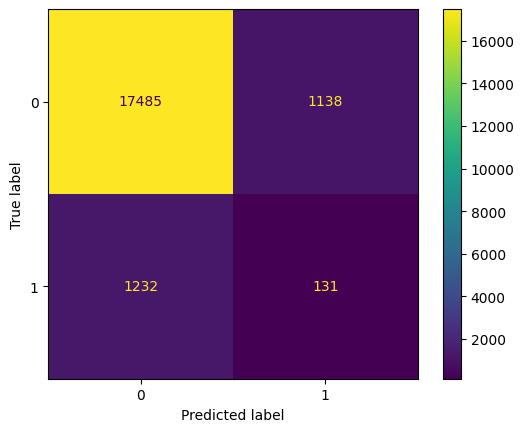

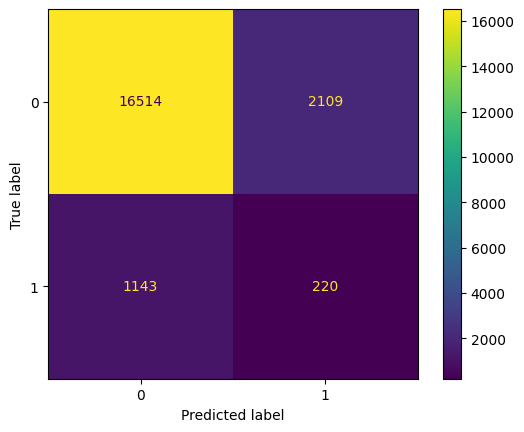

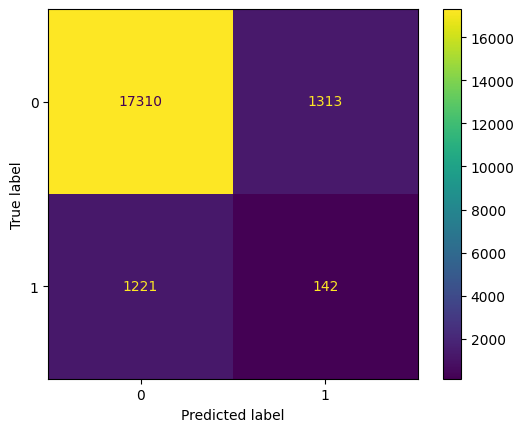

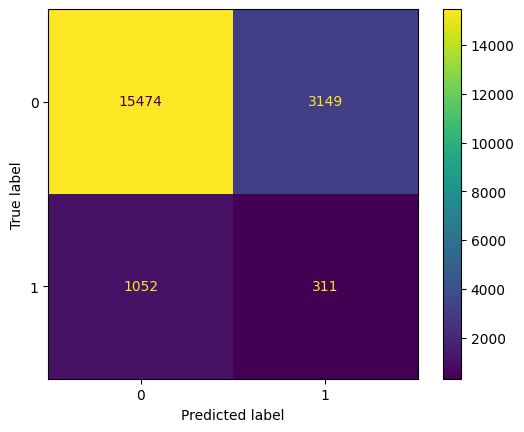

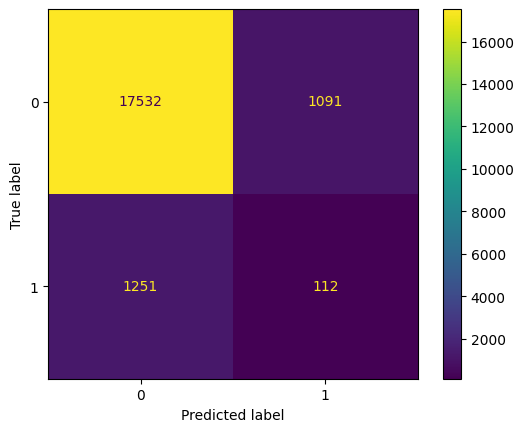

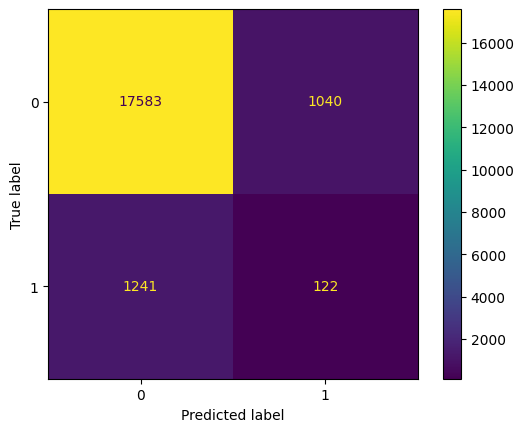

In [42]:
#simple run

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import pandas as pd

for features in [core_raw,
                 core_with_buckets,
                 core_raw+usage_feature_engineered,
                 core_raw+interaction_feature_engineered,
                 core_with_buckets+usage_feature_engineered,
                 core_with_buckets+interaction_feature_engineered,
                 core_raw+usage_feature_engineered+interaction_feature_engineered,
                 core_with_buckets+usage_feature_engineered+interaction_feature_engineered]:
    
    print("\n\nUsing features:", features)
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_leaf=50,     
        class_weight="balanced", 
        n_jobs=-1,
        random_state=42,
    )
    rf.fit(X_train[features], y_train)

    rf_prob = rf.predict_proba(X_test[features])[:, 1]
    rf_pred = (rf_prob >= 0.55).astype(int)

    print(classification_report(y_test, rf_pred, digits=3))
    ConfusionMatrixDisplay.from_predictions(y_test, rf_pred)

In [43]:
X_train.columns

Index(['rating_account_id', 'customer_id', 'age', 'contract_lifetime_days',
       'remaining_binding_days', 'has_special_offer', 'is_magenta1_customer',
       'available_gb', 'gross_mrc', 'smartphone_brand', 'available_gb_missing',
       'is_premium_device', 'remaining_binding_days_bucket', 'mrc_bucket',
       'contract_term_bucket', 'age_bucket',
       'remaining_binding_days_bucket_0-30',
       'remaining_binding_days_bucket_31-90',
       'remaining_binding_days_bucket_91-180',
       'remaining_binding_days_bucket_>180', 'mrc_bucket_Mid (30-50€)',
       'mrc_bucket_High (>50€)', 'contract_term_bucket_1-2y',
       'contract_term_bucket_2-3y', 'contract_term_bucket_3-5y',
       'age_bucket_25-45', 'age_bucket_46-60', 'age_bucket_>60',
       'smartphone_brand_OnePlus', 'smartphone_brand_Samsung',
       'smartphone_brand_Xiaomi', 'smartphone_brand_iPhone', 'total_used_gb',
       'avg_used_gb', 'std_used_gb', 'min_used_gb', 'max_used_gb',
       'usage_month_count', 'roaming

In [44]:


# define K’s to report
KS = (0.05, 0.10, 0.20)  # 5%, 10%, 20%

def precision_at_k(y_true, y_score, k):
    df = pd.DataFrame({"y": y_true.values, "p": y_score}).sort_values("p", ascending=False)
    n = max(1, int(len(df) * k))
    tp = int(df.head(n)["y"].sum())
    return tp / n


feats_raw = ['age','contract_lifetime_days','remaining_binding_days','gross_mrc',
             'available_gb','available_gb_missing','has_special_offer','is_magenta1_customer','is_premium_device']

feats_buckets = ['remaining_binding_days_bucket_0-30','remaining_binding_days_bucket_31-90',
                 'remaining_binding_days_bucket_91-180','remaining_binding_days_bucket_>180',
                 'mrc_bucket_Mid (30-50€)','mrc_bucket_High (>50€)',
                 'contract_term_bucket_1-2y','contract_term_bucket_2-3y','contract_term_bucket_3-5y',
                 'age_bucket_25-45','age_bucket_46-60','age_bucket_>60',
                 'available_gb','available_gb_missing','has_special_offer','is_magenta1_customer','is_premium_device']

feats_both = list(dict.fromkeys(feats_raw + feats_buckets))  # union, keep order

variants = {
    "Core RAW": feats_raw,
    "Core BUCKETS": feats_buckets,
    "RAW + BUCKETS": feats_both,
}



# baseline
base_rate = y_test.mean()
print(f"Baseline upsell rate in test: {base_rate:.4f}\n")

for name, feats in variants.items():
    rf = RandomForestClassifier(n_estimators=100,
    max_depth=None,
    min_samples_leaf=50,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,)
    rf.fit(X_train[feats], y_train)
    prob = rf.predict_proba(X_test[feats])[:, 1]

    print(f"{name} — n_features={len(feats)}")
    for k in KS:
        p_at_k = precision_at_k(y_test, prob, k)
        print(f"  Precision@{int(k*100)}%: {p_at_k:.4f}")
    print()

Baseline upsell rate in test: 0.0682

Core RAW — n_features=9
  Precision@5%: 0.0971
  Precision@10%: 0.1051
  Precision@20%: 0.1003

Core BUCKETS — n_features=17
  Precision@5%: 0.1021
  Precision@10%: 0.1001
  Precision@20%: 0.0918

RAW + BUCKETS — n_features=21
  Precision@5%: 0.0901
  Precision@10%: 0.0971
  Precision@20%: 0.1026



In [45]:
# How do we want to measure model performance? 
# How bad is it a false positive? maybe define a cost function
# more tuning, selection
# more feature engineering
# seasonality
# more information - i.e. competitors' offers